# London Fire Brigade Incidents' Cost Prediction

![londonfb](https://wallpaperaccess.com/full/2253810.jpg)





## Contents

* [Introduction](#intro)
* [Importing modules](#modules)
* [Collection & Cleansing](#coll)
* [Feature Engineering](#feng)
* [Exploratory Analysis](#exp)
* [Algorithm Implementation (LightGBM)](#lgbm)
* [Epitome](#epi)
* [Additional Resources](#add)
* [About](#about)

## <a name="intro"></a> Introduction

The Mayor of London wrote to the London Fire Commissioner (LFC) on 24 November 2021 to confirm the funding amounts as set 
out in his Guidance, which are for proposed funding levels for 2022/23 of £418.5m, 2023/24
of £431.2m, <br />
and 2024/25 of £445.8m. <br />

After that, a LFB (London Fire Brigade) report updates the budget proposals included in the Budget Submission to the Mayor in
November 2021 (LFC-0625). <br />It proposes a balanced budget for 2022/23 which is in line with
the funding agreed for the LFC of £421.8m in the Mayor’s Final Draft Consolidated Budget,
which was considered at the meeting of the London Assembly on 24 February 2022.

The Commissioner also pretends to update 2023 & 2024 budgets to £435.7m and £452.8m

All the information can be revised on [Additional Resources](#add)

This ML-project aims to **predict the notional cost of an incident** caused in London-city territory & solved by the LFB,<br />
helping the organization's system and its relative budget.

Incidents responded to by the LFB (London Fire Brigade) from 01/01/2009.

## <a name="modules"></a> Importing modules

To execute algorithms & plot some results we will need to import modules.

As the Kaggle Notebook frame supports connection with uploaded data, we won't need to import it from a local path

In [96]:
import numpy as np # linear algebra
np.set_printoptions(precision=2)

import math

import pandas as pd # data processing
pd.set_option('precision', 2)
pd.set_option('float_format', '{:.2f}'.format)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from matplotlib.cbook import boxplot_stats

import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn import metrics

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/london-fire-brigade-incidents/lfb_incident.csv
/kaggle/input/london-fire-brigade-incidents/lfb_metadata.csv


## <a name="coll"></a> Collection & Cleansing

There are two files included in this set:

* lfb_incident: all details of incidents
* lfb_metadata: column descriptors and record examples

These data tables are updated quarterly.

First of all, we will collect the data & its metadata from a .csv stored in Kaggle.

(https://www.kaggle.com/datasets/jonbown/london-fire-brigade-incidents)

### <a name="feng"></a> Feature Engineering:

* +1.4M samples (aprox. 500MB of data)
* 39 features (categorical & non-categorical)
* These details include location, date, time, response time, how many pumps, group that responded, etc.
* **'Notional Cost'** and from now on **'cost'** is our target feature


Before deciding the algorithm to predict the cost, we will study the relevant columns of the dataframe, its NaN values, outliers and unwanted data points.

In [97]:
md = pd.read_csv('../input/london-fire-brigade-incidents/lfb_metadata.csv',low_memory=False)

new_row = {'Column':'NumCalls', 'Description':"Number of calls made by incident"}
md = md.append(new_row, ignore_index=True)

display(md[["Column","Description"]]) # Printing relevant columns from the metadata

,Column,Description
0,IncidentNumber,LFB Incident Number
1,DateOfCall,Date of 999 call
2,CalYear,Year of 999 call
3,TimeOfCall,Time of 999 call
4,HourOfCall,Hour of 999 call
5,IncidentGroup,High level incident category
6,StopCodeDescription,Detailed incident category
7,SpecialServiceType,Further detail for special services incident c...
8,PropertyCategory,High level property descriptor
9,PropertyType,Detailed property descriptor


In [98]:
df = pd.read_csv('../input/london-fire-brigade-incidents/lfb_incident.csv',low_memory=False) #Reading data as a dataframe
pd.set_option('max_columns', None)

In [99]:
display(df)

,IncidentNumber,DateOfCall,CalYear,TimeOfCall,HourOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,AddressQualifier,Postcode_full,Postcode_district,UPRN,USRN,IncGeo_BoroughCode,IncGeo_BoroughName,ProperCase,IncGeo_WardCode,IncGeo_WardName,IncGeo_WardNameNew,Easting_m,Northing_m,Easting_rounded,Northing_rounded,Latitude,Longitude,FRS,IncidentStationGround,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpHoursRoundUp,Notional Cost (£),NumCalls
0,235138081,01 Jan 2009,2009,00:00:37,0,Special Service,Special Service,RTC,Road Vehicle,Car,In street close to gazetteer location,SW11 4LB,SW11,NaN,NaN,E09000032,WANDSWORTH,Wandsworth,E05000620,Queenstown,Queenstown,528652.00,176830.00,528650,176850,51.48,-0.15,London,Battersea,319.00,Battersea,342.00,Clapham,2.00,2.00,2.00,1.00,255.00,1.00
1,1091,01 Jan 2009,2009,00:00:46,0,Special Service,Special Service,Assist other agencies,Outdoor,Lake/pond/reservoir,Open land/water - nearest gazetteer location,SE1 7SG,SE1,NaN,NaN,E09000022,LAMBETH,Lambeth,E05000416,Bishop's,Bishop's,530485.00,179007.00,530450,179050,51.49,-0.12,London,Lambeth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00
2,2091,01 Jan 2009,2009,00:03:00,0,Fire,Secondary Fire,NaN,Outdoor,Road surface/pavement,In street outside gazetteer location,N9 9EL,N9,NaN,NaN,E09000010,ENFIELD,Enfield,E05000201,Haselbury,Haselbury,533773.00,194492.00,533750,194450,51.63,-0.07,London,Edmonton,308.00,Edmonton,NaN,NaN,1.00,1.00,1.00,1.00,255.00,2.00
3,3091,01 Jan 2009,2009,00:04:27,0,Fire,Secondary Fire,NaN,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,UB10 0DG,UB10,100021491527.00,21401491.00,E09000017,HILLINGDON,Hillingdon,E05000332,Hillingdon East,Hillingdon East,507738.00,182805.00,507750,182850,51.53,-0.45,London,Hillingdon,210.00,Hillingdon,NaN,NaN,1.00,1.00,1.00,1.00,255.00,2.00
4,5091,01 Jan 2009,2009,00:05:39,0,Fire,Secondary Fire,NaN,Outdoor,Cycle path/public footpath/bridleway,In street outside gazetteer location,N7 8HG,N7,NaN,NaN,E09000019,ISLINGTON,Islington,E05000375,Holloway,Holloway,531058.00,185307.00,531050,185350,51.55,-0.11,London,Holloway,233.00,Holloway,250.00,Holloway,1.00,2.00,2.00,1.00,255.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465055,096399-30062022,30 Jun 2022,2022,23:42:53,23,False Alarm,AFA,NaN,Non Residential,Warehouse,Correct incident location,TW6 3RT,TW6,10009947931.00,21401748.00,E09000017,HILLINGDON,Hillingdon,E05013570,HEATHROW VILLAGES,HEATHROW VILLAGES,506341.00,174670.00,506350,174650,51.46,-0.47,London,Heathrow,510.00,Feltham,NaN,NaN,1.00,1.00,1.00,1.00,364.00,2.00
1465056,096401-30062022,30 Jun 2022,2022,23:46:26,23,Special Service,Special Service,Effecting entry/exit,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Correct incident location,NaN,N19,0.00,21606466.00,E09000019,ISLINGTON,Islington,E05013712,TOLLINGTON,TOLLINGTON,NaN,NaN,530250,186950,NaN,NaN,London,Holloway,370.00,Kentish Town,NaN,NaN,1.00,1.00,1.00,1.00,364.00,2.00
1465057,096402-30062022,30 Jun 2022,2022,23:46:44,23,False Alarm,AFA,NaN,Non Residential,Pub/wine bar/bar,Correct incident location,UB4 8HX,UB4,100023417299.00,21402032.00,E09000017,HILLINGDON,Hillingdon,E05013582,WOOD END,WOOD END,508781.00,181838.00,508750,181850,51.52,-0.43,London,Hillingdon,219.00,Hillingdon,NaN,NaN,1.00,1.00,1.00,1.00,364.00,1.00
1465058,096403-30062022,30 Jun 2022,2022,23:47:55,23,False Alarm,False alarm - Good intent,NaN,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,Correct incident location,NaN,E1W,0.00,22700543.00,E09000030,TOWER HAMLETS,Tower Hamlets,E05009332,SHADWELL,SHADWELL,NaN,NaN,535650,180950,NaN,NaN,London,Shadwell,321.00,Shadwell,NaN,NaN,1.00,1.00,1.00,1.00,364.00,1.00


In [100]:
df.isnull().sum(axis = 0) # Checking the NaN values for every column

IncidentNumber                                  0
DateOfCall                                      0
CalYear                                         0
TimeOfCall                                      0
HourOfCall                                      0
IncidentGroup                                   0
StopCodeDescription                             0
SpecialServiceType                        1005856
PropertyCategory                                0
PropertyType                                    0
AddressQualifier                                0
Postcode_full                              706377
Postcode_district                               0
UPRN                                       141333
USRN                                       162871
IncGeo_BoroughCode                              0
IncGeo_BoroughName                              0
ProperCase                                      0
IncGeo_WardCode                                 4
IncGeo_WardName                                 4


In [101]:
df['Month'] = pd.to_datetime(df['DateOfCall'], format='%d %b %Y').dt.month #Tranforming data
df['TimeOfCall'] = pd.to_timedelta(df['TimeOfCall']).dt.total_seconds()

In [102]:
df = df[['IncidentNumber', 'DateOfCall', 'CalYear', 'TimeOfCall', 'HourOfCall',
       'IncidentGroup', 'StopCodeDescription', 'SpecialServiceType',
       'PropertyCategory', 'PropertyType', 'AddressQualifier', 'Postcode_full',
       'Postcode_district', 'UPRN', 'USRN', 'IncGeo_BoroughCode',
       'IncGeo_BoroughName', 'ProperCase', 'IncGeo_WardCode',
       'IncGeo_WardName', 'IncGeo_WardNameNew', 'Easting_m', 'Northing_m',
       'Easting_rounded', 'Northing_rounded', 'Latitude', 'Longitude', 'FRS',
       'IncidentStationGround', 'FirstPumpArriving_AttendanceTime',
       'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_AttendanceTime',
       'SecondPumpArriving_DeployedFromStation',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
       'PumpHoursRoundUp', 'NumCalls','Month','Notional Cost (£)']]

df= df.rename(columns={'Notional Cost (£)': 'cost','CalYear': 'year'}) #renaming columns for a time-saver solution

display(df)

,IncidentNumber,DateOfCall,year,TimeOfCall,HourOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,AddressQualifier,Postcode_full,Postcode_district,UPRN,USRN,IncGeo_BoroughCode,IncGeo_BoroughName,ProperCase,IncGeo_WardCode,IncGeo_WardName,IncGeo_WardNameNew,Easting_m,Northing_m,Easting_rounded,Northing_rounded,Latitude,Longitude,FRS,IncidentStationGround,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpHoursRoundUp,NumCalls,Month,cost
0,235138081,01 Jan 2009,2009,37.00,0,Special Service,Special Service,RTC,Road Vehicle,Car,In street close to gazetteer location,SW11 4LB,SW11,NaN,NaN,E09000032,WANDSWORTH,Wandsworth,E05000620,Queenstown,Queenstown,528652.00,176830.00,528650,176850,51.48,-0.15,London,Battersea,319.00,Battersea,342.00,Clapham,2.00,2.00,2.00,1.00,1.00,1,255.00
1,1091,01 Jan 2009,2009,46.00,0,Special Service,Special Service,Assist other agencies,Outdoor,Lake/pond/reservoir,Open land/water - nearest gazetteer location,SE1 7SG,SE1,NaN,NaN,E09000022,LAMBETH,Lambeth,E05000416,Bishop's,Bishop's,530485.00,179007.00,530450,179050,51.49,-0.12,London,Lambeth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1,NaN
2,2091,01 Jan 2009,2009,180.00,0,Fire,Secondary Fire,NaN,Outdoor,Road surface/pavement,In street outside gazetteer location,N9 9EL,N9,NaN,NaN,E09000010,ENFIELD,Enfield,E05000201,Haselbury,Haselbury,533773.00,194492.00,533750,194450,51.63,-0.07,London,Edmonton,308.00,Edmonton,NaN,NaN,1.00,1.00,1.00,1.00,2.00,1,255.00
3,3091,01 Jan 2009,2009,267.00,0,Fire,Secondary Fire,NaN,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,UB10 0DG,UB10,100021491527.00,21401491.00,E09000017,HILLINGDON,Hillingdon,E05000332,Hillingdon East,Hillingdon East,507738.00,182805.00,507750,182850,51.53,-0.45,London,Hillingdon,210.00,Hillingdon,NaN,NaN,1.00,1.00,1.00,1.00,2.00,1,255.00
4,5091,01 Jan 2009,2009,339.00,0,Fire,Secondary Fire,NaN,Outdoor,Cycle path/public footpath/bridleway,In street outside gazetteer location,N7 8HG,N7,NaN,NaN,E09000019,ISLINGTON,Islington,E05000375,Holloway,Holloway,531058.00,185307.00,531050,185350,51.55,-0.11,London,Holloway,233.00,Holloway,250.00,Holloway,1.00,2.00,2.00,1.00,1.00,1,255.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465055,096399-30062022,30 Jun 2022,2022,85373.00,23,False Alarm,AFA,NaN,Non Residential,Warehouse,Correct incident location,TW6 3RT,TW6,10009947931.00,21401748.00,E09000017,HILLINGDON,Hillingdon,E05013570,HEATHROW VILLAGES,HEATHROW VILLAGES,506341.00,174670.00,506350,174650,51.46,-0.47,London,Heathrow,510.00,Feltham,NaN,NaN,1.00,1.00,1.00,1.00,2.00,6,364.00
1465056,096401-30062022,30 Jun 2022,2022,85586.00,23,Special Service,Special Service,Effecting entry/exit,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Correct incident location,NaN,N19,0.00,21606466.00,E09000019,ISLINGTON,Islington,E05013712,TOLLINGTON,TOLLINGTON,NaN,NaN,530250,186950,NaN,NaN,London,Holloway,370.00,Kentish Town,NaN,NaN,1.00,1.00,1.00,1.00,2.00,6,364.00
1465057,096402-30062022,30 Jun 2022,2022,85604.00,23,False Alarm,AFA,NaN,Non Residential,Pub/wine bar/bar,Correct incident location,UB4 8HX,UB4,100023417299.00,21402032.00,E09000017,HILLINGDON,Hillingdon,E05013582,WOOD END,WOOD END,508781.00,181838.00,508750,181850,51.52,-0.43,London,Hillingdon,219.00,Hillingdon,NaN,NaN,1.00,1.00,1.00,1.00,1.00,6,364.00
1465058,096403-30062022,30 Jun 2022,2022,85675.00,23,False Alarm,False alarm - Good intent,NaN,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,Correct incident location,NaN,E1W,0.00,22700543.00,E09000030,TOWER HAMLETS,Tower Hamlets,E05009332,SHADWELL,SHADWELL,NaN,NaN,535650,180950,NaN,NaN,London,Shadwell,321.00,Shadwell,NaN,NaN,1.00,1.00,1.00,1.00,1.00,6,364.00


In [103]:
a = df.duplicated(keep='first').sum() # Scrutinizing duplicated rows
print(a)

0


In [104]:
print("Unique values for Incident Group: "+str(df.IncidentGroup.unique().size))
print("Unique values for Month: "+str(df.Month.unique().size))
print("Unique values for StopCodeDescription: "+str(df.StopCodeDescription.unique().size))
print("Unique values for PropertyCategory: "+str(df.PropertyCategory.unique().size))
print("Unique values for PropertyType: "+str(df.PropertyType.unique().size))
print("Unique values for IncGeo_BoroughCode: "+str(df.IncGeo_BoroughCode.unique().size))
print("Unique values for AddressQualifier: "+str(df.AddressQualifier.unique().size))
print("Unique values for Postcode_district: "+str(df.Postcode_district.unique().size))
print("Unique values for USRN: "+str(df.USRN.unique().size))

Unique values for Incident Group: 3
Unique values for Month: 12
Unique values for StopCodeDescription: 10
Unique values for PropertyCategory: 9
Unique values for PropertyType: 291
Unique values for IncGeo_BoroughCode: 33
Unique values for AddressQualifier: 11
Unique values for Postcode_district: 328
Unique values for USRN: 51705


In [105]:
df=df.dropna(subset=['cost']) #Dropping NaN values for label column

## <a name="exp"></a> Exploratory Analysis

We will perform initial investigations on data so as to discover patterns, to spot anomalies, to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

In [106]:
b = df.groupby(["Month"])["Month"].count()
print(b)
print(b.max())

Month
1     117117
2     110622
3     122019
4     120824
5     128756
6     132196
7     133922
8     124443
9     118602
10    121100
11    114169
12    112847
Name: Month, dtype: int64
133922


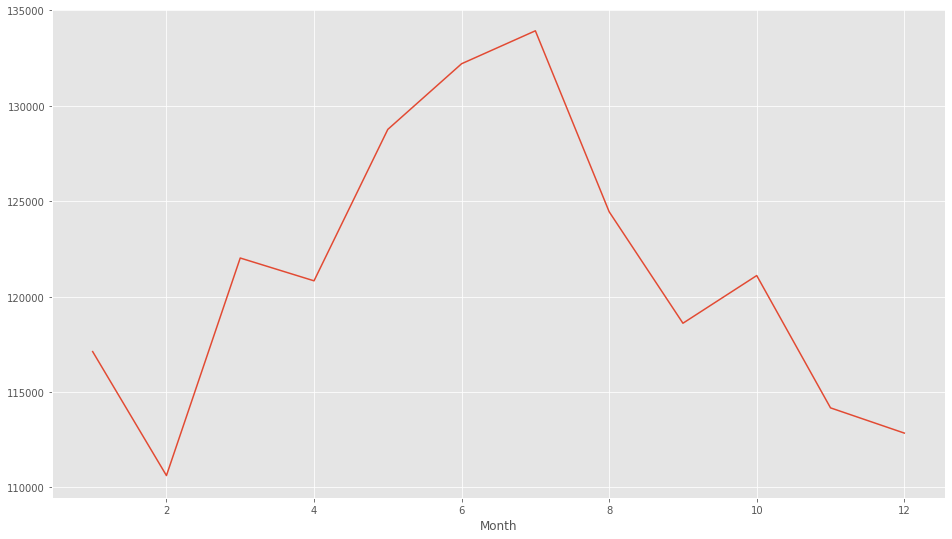

In [107]:
b.plot()
plt.show()

In [108]:
a = df.groupby(["HourOfCall"])["HourOfCall"].count()
print(a)
print(a.max())

HourOfCall
0     46528
1     37781
2     30919
3     26980
4     23794
5     23322
6     27731
7     38633
8     52163
9     63131
10    68220
11    72953
12    75997
13    78315
14    78313
15    80426
16    83076
17    88629
18    91707
19    90014
20    83168
21    74041
22    65110
23    55666
Name: HourOfCall, dtype: int64
91707


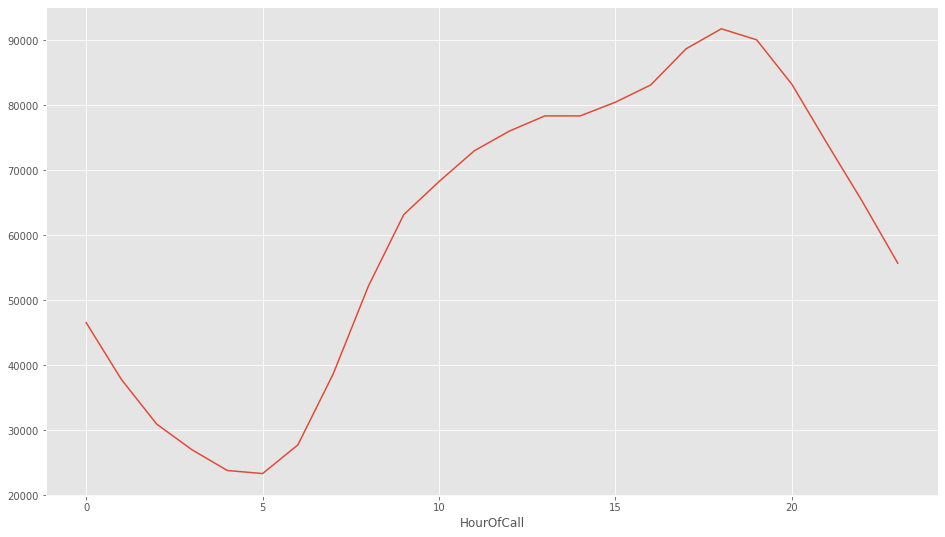

In [109]:
a.plot()
plt.show()

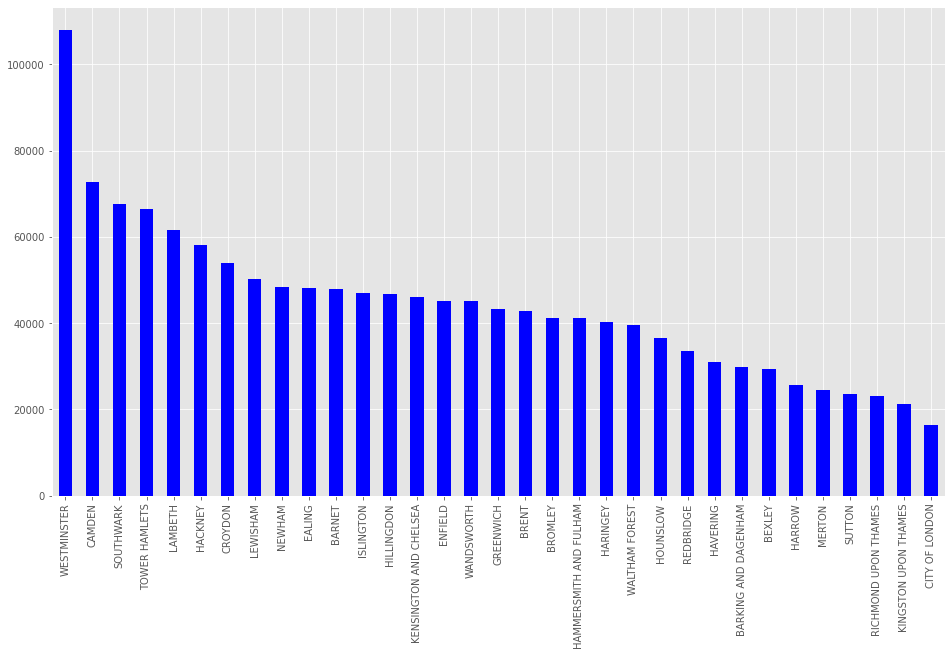

In [110]:
df["IncGeo_BoroughName"].value_counts().plot(kind='bar',color='blue')
plt.show()

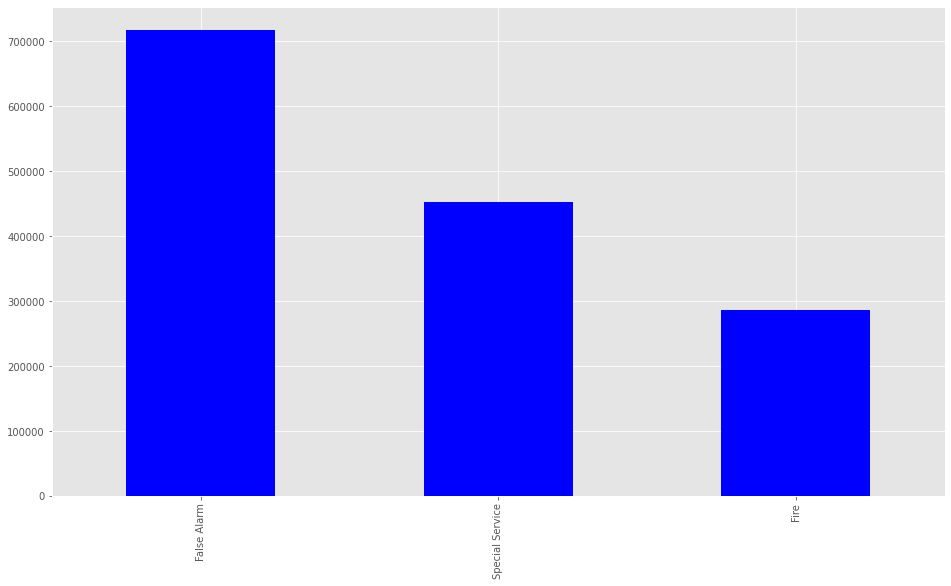

In [111]:
df["IncidentGroup"].value_counts().plot(kind='bar',color='blue')
plt.show()


In [112]:
boxplot_stats(df['cost'],whis=2)

[{'mean': 409.6076367363555,
  'iqr': 86.0,
  'cilo': 325.8881269659459,
  'cihi': 326.1118730340541,
  'whishi': 510.0,
  'whislo': 255.0,
  'fliers': array([2805.,  765., 6375., ...,  728.,  728.,  728.]),
  'q1': 260.0,
  'med': 326.0,
  'q3': 346.0}]

In [113]:
print(len(boxplot_stats(df['cost'])[0]["fliers"]))
print(boxplot_stats(df['cost'])[0]["fliers"].max())
print(boxplot_stats(df['cost'])[0]["fliers"].min())

184525
2277860.0
510.0


In [114]:
outliers = (boxplot_stats(df['cost'])[0]["fliers"])
outliers_end = outliers[outliers > outliers[0]*1.5]
print(len(outliers_end))
print(outliers_end.min())

63912
780.0


In [115]:
df = df.loc[~df['cost'].isin(outliers_end)]

In [116]:
df=(
    df
    .assign(
        IncidentGroup=df.IncidentGroup.astype('category').cat.codes,
        PropertyCategory=df.PropertyCategory.astype('category').cat.codes,
        PropertyType=df.PropertyType.astype('category').cat.codes,
        AddressQualifier=df.AddressQualifier.astype('category').cat.codes,
        Postcode_district=df.Postcode_district.astype('category').cat.codes,
        SpecialServiceType=df.SpecialServiceType.astype('category').cat.codes,
        StopCodeDescription=df.StopCodeDescription.astype('category').cat.codes,
        IncGeo_BoroughCode=df.IncGeo_BoroughCode.astype('category').cat.codes
    )
)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1392705 entries, 0 to 1465059
Data columns (total 40 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   IncidentNumber                          1392705 non-null  object 
 1   DateOfCall                              1392705 non-null  object 
 2   year                                    1392705 non-null  int64  
 3   TimeOfCall                              1392705 non-null  float64
 4   HourOfCall                              1392705 non-null  int64  
 5   IncidentGroup                           1392705 non-null  int8   
 6   StopCodeDescription                     1392705 non-null  int8   
 7   SpecialServiceType                      1392705 non-null  int8   
 8   PropertyCategory                        1392705 non-null  int8   
 9   PropertyType                            1392705 non-null  int16  
 10  AddressQualifier              

In [117]:
a = df.shape[0]
df = df.iloc[:, [2, 3, 4, 5, 12, 14, 15, 34, 35, 36, 37, 38, 39]].dropna() #2, 3, 15, 35, 36, 38, 39
b = df.shape[0]
print("Dropped rows: "+str(a-b))
print("Dataframe length before dropping rows: "+str(a))
print("Dataframe length after dropping rows: "+str(b))

Dropped rows: 155910
Dataframe length before dropping rows: 1392705
Dataframe length after dropping rows: 1236795


In [118]:
print(df.describe())

            year  TimeOfCall  HourOfCall  IncidentGroup  Postcode_district  \
count 1236795.00  1236795.00  1236795.00     1236795.00         1236795.00   
mean     2015.45    50258.31       13.46           0.77             160.26   
std         4.01    22304.16        6.19           0.89              88.96   
min      2009.00        0.00        0.00           0.00               0.00   
25%      2012.00    35612.00        9.00           0.00              94.00   
50%      2016.00    52774.00       14.00           0.00             160.00   
75%      2019.00    68326.00       18.00           2.00             232.00   
max      2022.00    86399.00       23.00           2.00             327.00   

             USRN  IncGeo_BoroughCode  NumPumpsAttending  PumpCount  \
count  1236795.00          1236795.00         1236795.00 1236795.00   
mean  20261117.86               17.03               1.53       1.54   
std    4265335.44                9.76               0.76       0.77   
min          

In [119]:
print("Mode: "+str(df['cost'].mode().values[0]))

Mode: 260.0


In [120]:
print("Number (mean) of incidents per year: "+str(df.groupby(["year"])["year"].count().mean()))
print("Cost (mean) of incidents per year: "+str(df.groupby(["year"])["cost"].sum().mean()))
print("Total cost: £"+ str(df['cost'].sum()))

Number (mean) of incidents per year: 88342.5
Cost (mean) of incidents per year: 29345393.07142857
Total cost: £410835503.0


After cleaning & preprocessing, we discovered some important points (code-detailed above) & drew related conclusions:

* The mean cost of an incident is **£332.18**
* The median cost of an incident is **£326.00**
* **£260,00** is the most common value found for each cost
* The average number of incidents per year is **88.342,5**
* The average cost of incidents per year is **£29.345.393,07**
* For the last 13 years, LFB had spent **£410.835.503,0** in incidents
* Most of the incidents occur between **6pm and 7pm**
* **Westminster** is the most affected borough
* **False Alarms** represents **more than half** of the incidents 

## <a name="lgbm"></a> Algorithm Implementation (LightGBM)

![gbm](https://miro.medium.com/max/1400/1*E006sjlIjabDJ3jNixRSnA.png)

**LightGBM** is a gradient boosting framework that uses tree based learning algorithms (Supervised Machine Learning). It is designed to be distributed and efficient with the following advantages: </br>
* Faster training speed
* Higher efficiency
* Lower memory usage.

In [121]:
df.head(10)

,year,TimeOfCall,HourOfCall,IncidentGroup,Postcode_district,USRN,IncGeo_BoroughCode,NumPumpsAttending,PumpCount,PumpHoursRoundUp,NumCalls,Month,cost
3,2009,267.00,0,1,263,21401491.00,16,1.00,1.00,1.00,2.00,1,255.00
5,2009,363.00,0,0,155,20499122.00,6,2.00,2.00,1.00,1.00,1,255.00
7,2009,822.00,0,1,255,21500957.00,17,2.00,2.00,2.00,1.00,1,510.00
8,2009,891.00,0,1,61,21604971.00,18,1.00,1.00,1.00,2.00,1,255.00
9,2009,897.00,0,0,310,20401090.00,6,1.00,1.00,1.00,1.00,1,255.00
10,2009,962.00,0,1,140,20703023.00,9,2.00,2.00,2.00,1.00,1,510.00
11,2009,1078.00,0,2,201,22500901.00,27,1.00,1.00,1.00,1.00,1,255.00
12,2009,1140.00,0,1,255,21500344.00,17,1.00,1.00,1.00,1.00,1,255.00
14,2009,1408.00,0,0,86,20703007.00,9,1.00,1.00,2.00,1.00,1,510.00
15,2009,1418.00,0,2,56,21690439.00,0,1.00,1.00,1.00,1.00,1,255.00


In [122]:
X = df.iloc[:,:12]
y = df.iloc[:,12] # y as 'cost'

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specifying the configurations as a dict    
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
evals_result = {}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=[lgb_eval,lgb_train],
                callbacks=[lgb.early_stopping(stopping_rounds=2000)],
                valid_names=['val', 'train'],
                evals_result=evals_result,)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138085 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 2000 rounds
Did not meet early stopping. Best iteration is:
[2000]	train's l2: 0.0654654	train's l1: 0.158766	val's l2: 0.0665087	val's l1: 0.159254


Plot metrics recorded during training...


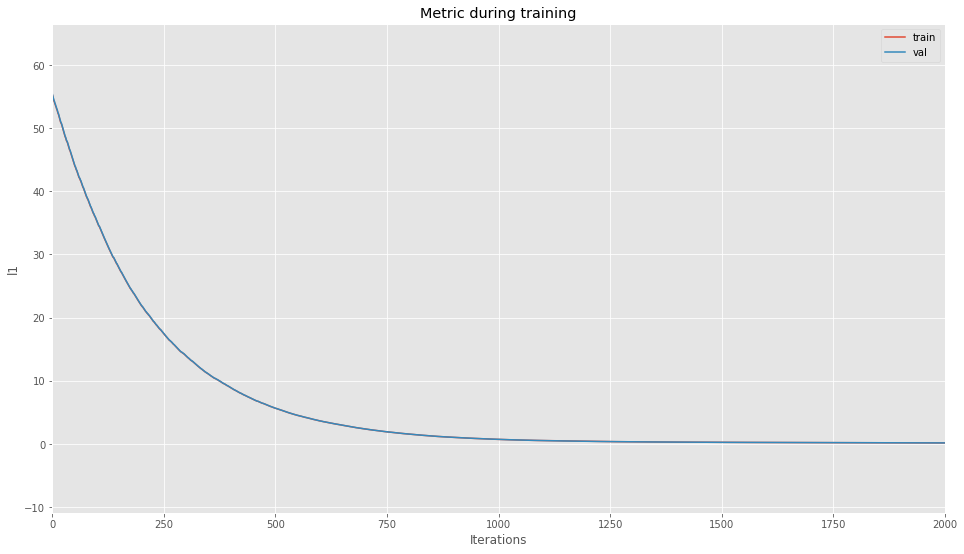

In [123]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='l1')
plt.show()

In [124]:
y_pred = gbm.predict(X_test)

results = pd.DataFrame({'y': y_test, 'y_pred': y_pred})

<AxesSubplot:>

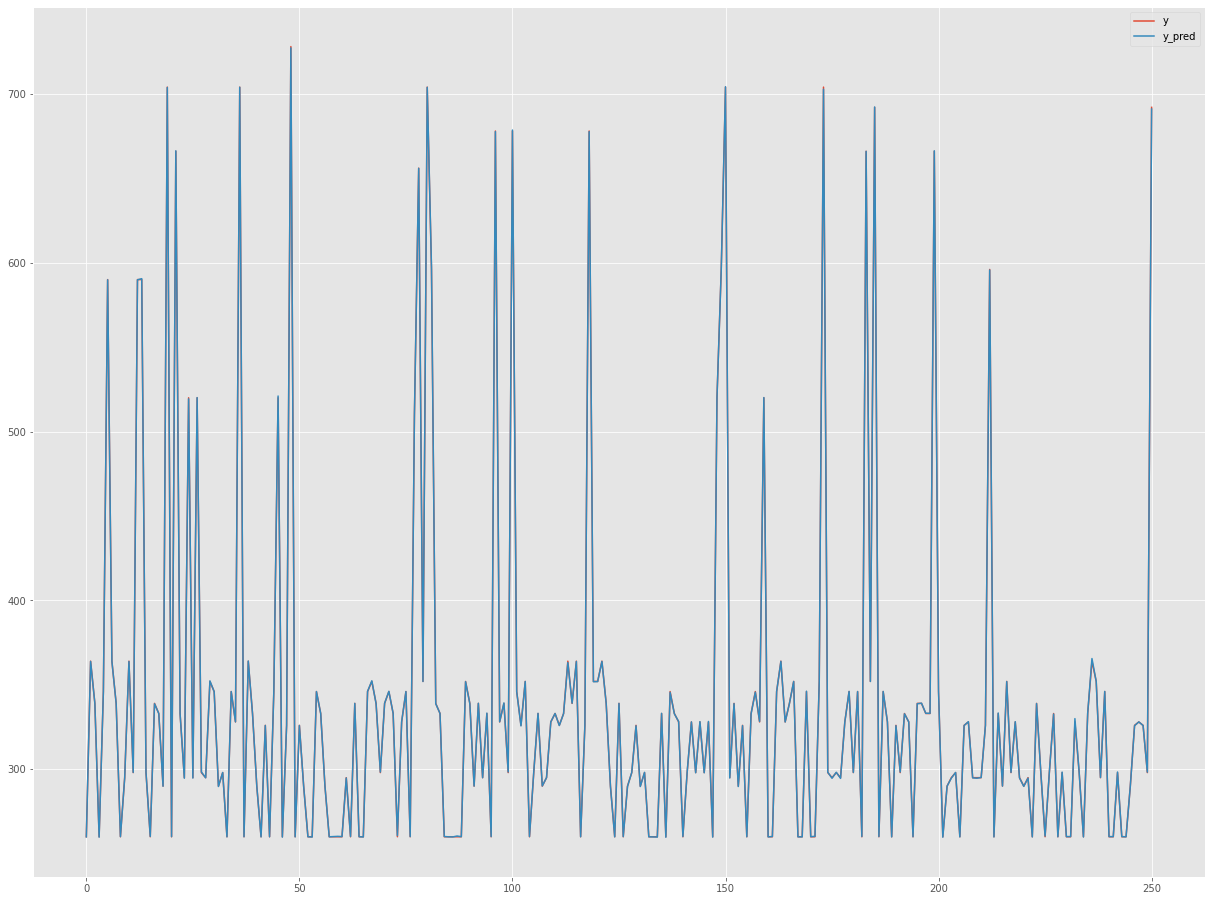

In [125]:
results.reset_index().loc[:250,["y","y_pred"]].plot(figsize=(21,16))

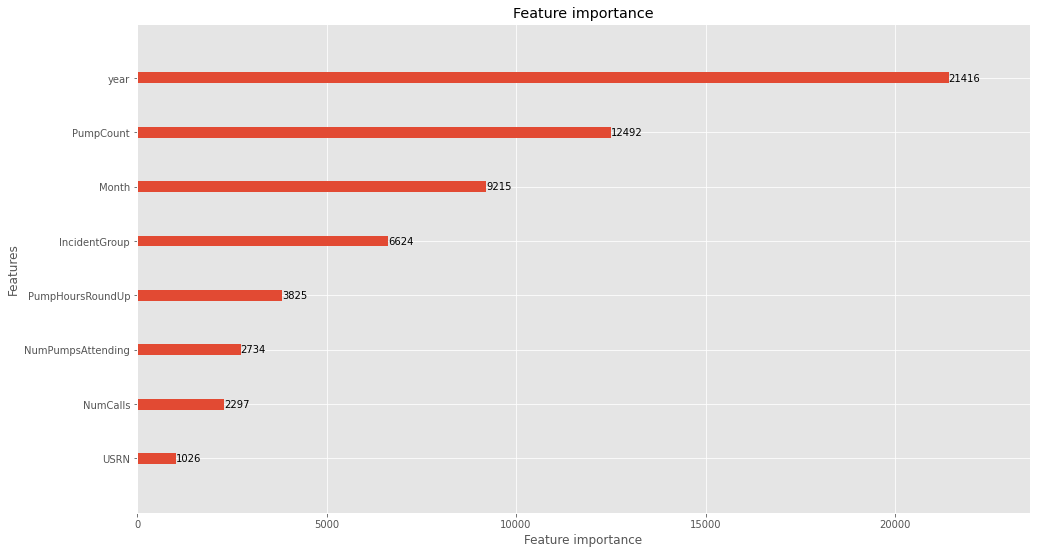

In [128]:
lgb.plot_importance(gbm, ignore_zero=False, max_num_features=8)
plt.show()

## <a name="epi"></a> Epitome

Given this model (created using LightGBM), if a new incident comes up, it will yield an estimated mean absolute error (L1) of **0.159254** & a mean squared error (L2) of **0.0665087**

## <a name="add"></a> Additional Resources

* [LightGBM Documentation](https://lightgbm.readthedocs.io/en/v3.3.2/)
* [Listed Incidents | London Fire Brigade](https://www.london-fire.gov.uk/incidents/)
* [LFB 2022/2023 Budget](https://www.london-fire.gov.uk/media/6430/20220330-lfc0679-final-202223-budget.pdf)

## <a name="about"></a> About

**Author:** David Serantes, Data Analyst.<br />
**Updated On:** 2022-09-25
